Prophet Multi-Variable Forecasting. Datetime, y = Protests (frequency), and additional variable of SCOTUS cases.

# Import Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet

%matplotlib inline

## Protest Data

In [4]:
protest_2017_2020 = pd.read_csv("/content/ccc_compiled_20172020.csv", encoding='latin-1')
protest_2021_2024 = pd.read_csv("/content/ccc_compiled_20212024.csv", encoding='latin-1')

<ipython-input-4-4fa6a05f8a4c>:1: DtypeWarning: Columns (6,22,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  protest_2017_2020 = pd.read_csv("/content/ccc_compiled_20172020.csv", encoding='latin-1')
<ipython-input-4-4fa6a05f8a4c>:2: DtypeWarning: Columns (22,24,26,33,34,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  protest_2021_2024 = pd.read_csv("/content/ccc_compiled_20212024.csv", encoding='latin-1')


In [6]:
# change data type of date column to datatime
protest_2017_2020["date"] = pd.to_datetime(protest_2017_2020["date"])
protest_2021_2024["date"] = pd.to_datetime(protest_2021_2024["date"])

In [10]:
# subset protest_2021_2024 to just 2021 to 2023
protest_2021_2023 = protest_2021_2024[protest_2021_2024["date"] <= pd.to_datetime('2023-12-31')]
# combine dataframes to get protests from 2017 to 2023
protest_2017_2023 = pd.concat([protest_2017_2020, protest_2021_2023], ignore_index=True)
protest_2017_2023.head()

,date,locality,state,location_detail,online,type,macroevent,actors,claims,valence,...,participants,claims_summary,claims_verbatim,issue_tags_summary,issue_tags_verbatim,issue_tags,participant_measures,police_measures,participant_deaths,police_deaths
0,2017-01-01,Washington,DC,Lafayette Square Park,0.0,vigil,NaN,NaN,"for banning nuclear weapons, for peace",0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01,Mankato,MN,NaN,0.0,vigil,NaN,Peace Vigil Mankato,for peace,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01,Minneapolis,MN,U.S. Bank Stadium,0.0,protest; banner drop,NaN,general protestors,"against the Dakota Access Pipeline, for indige...",1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-01,Little Compton,RI,Town Green,0.0,vigil,NaN,Sakonnet Peace Alliance,"for peace, for gun control, for climate action",1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-01,Oak Ridge,TN,Y-12 National Security Complex,0.0,vigil,NaN,Oak Ridge Environmental Peace Alliance,for abolishing nuclear weapons,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
protest_df = protest_2017_2023.copy()

## SCOTUS Data

In [18]:
scotus_1946_2023 = pd.read_csv("/content/SCDB_2024_01_caseCentered_LegalProvision.csv")

In [20]:
scotus_1946_2023["dateDecision"] = pd.to_datetime(scotus_1946_2023["dateDecision"])
scotus_1946_2023

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,1946-11-18,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,1946-11-18,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-002,1946-002-02,1946-002-02-01,1946-002-02-01-01,1946-11-18,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
3,1946-002,1946-002-03,1946-002-03-01,1946-002-03-01-01,1946-11-18,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
4,1946-002,1946-002-04,1946-002-04-01,1946-002-04-01-01,1946-11-18,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13848,2023-060,2023-060-01,2023-060-01-01,2023-060-01-01-01,2024-06-27,6,NaN,144 S. Ct. 2015,219 L. Ed. 2d 804,2024 U.S. LEXIS 2849,...,NaN,NaN,5.0,508.0,NaN,NaN,111.0,1,6,3
13849,2023-060,2023-060-02,2023-060-02-01,2023-060-02-01-01,2024-06-27,6,NaN,144 S. Ct. 2015,219 L. Ed. 2d 804,2024 U.S. LEXIS 2849,...,NaN,NaN,5.0,508.0,NaN,NaN,111.0,1,6,3
13850,2023-061,2023-061-01,2023-061-01-01,2023-061-01-01-01,2024-07-01,1,NaN,144 S. Ct. 2312,219 L. Ed. 2d 991,2024 U.S. LEXIS 2886,...,1.0,NaN,1.0,131.0,NaN,111.0,111.0,1,6,3
13851,2023-062,2023-062-01,2023-062-01-01,2023-062-01-01-01,2024-07-01,1,NaN,144 S. Ct. 2383,219 L. Ed. 2d 1075,2024 U.S. LEXIS 2884,...,2.0,NaN,2.0,200.0,NaN,114.0,111.0,1,9,0


In [23]:
scotus_2017_2023 = scotus_1946_2023[scotus_1946_2023['dateDecision'] >= pd.to_datetime('2017-1-1')]
scotus_2017_2023.reset_index(drop=True, inplace=True)
scotus_2017_2023

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,2016-002,2016-002-01,2016-002-01-01,2016-002-01-01-01,2017-03-06,1,NaN,137 S. Ct. 855,197 L. Ed. 2d 107,2017 U.S. LEXIS 1574,...,2.0,NaN,2.0,215.0,NaN,106.0,106.0,1,5,3
1,2016-003,2016-003-01,2016-003-01-01,2016-003-01-01-01,2017-04-19,1,NaN,137 S. Ct. 1266,197 L. Ed. 2d 599,2017 U.S. LEXIS 2616,...,3.0,NaN,4.0,400.0,NaN,108.0,111.0,1,6,2
2,2016-005,2016-005-01,2016-005-01-01,2016-005-01-01-01,2017-03-21,1,NaN,137 S. Ct. 911,197 L. Ed. 2d 312,2017 U.S. LEXIS 2021,...,2.0,NaN,2.0,205.0,NaN,114.0,111.0,1,6,2
3,2016-006,2016-006-01,2016-006-01-01,2016-006-01-01-01,2017-02-22,1,NaN,137 S. Ct. 743,197 L. Ed. 2d 46,2017 U.S. LEXIS 1427,...,4.0,NaN,6.0,600.0,Individuals with Disabilities Education Act,114.0,111.0,1,8,0
4,2016-007,2016-007-01,2016-007-01-01,2016-007-01-01-01,2017-03-22,1,NaN,137 S. Ct. 1002,197 L. Ed. 2d 354,2017 U.S. LEXIS 2026,...,4.0,NaN,6.0,600.0,Copyright Act,108.0,111.0,1,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,2023-060,2023-060-01,2023-060-01-01,2023-060-01-01-01,2024-06-27,6,NaN,144 S. Ct. 2015,219 L. Ed. 2d 804,2024 U.S. LEXIS 2849,...,NaN,NaN,5.0,508.0,NaN,NaN,111.0,1,6,3
633,2023-060,2023-060-02,2023-060-02-01,2023-060-02-01-01,2024-06-27,6,NaN,144 S. Ct. 2015,219 L. Ed. 2d 804,2024 U.S. LEXIS 2849,...,NaN,NaN,5.0,508.0,NaN,NaN,111.0,1,6,3
634,2023-061,2023-061-01,2023-061-01-01,2023-061-01-01-01,2024-07-01,1,NaN,144 S. Ct. 2312,219 L. Ed. 2d 991,2024 U.S. LEXIS 2886,...,1.0,NaN,1.0,131.0,NaN,111.0,111.0,1,6,3
635,2023-062,2023-062-01,2023-062-01-01,2023-062-01-01-01,2024-07-01,1,NaN,144 S. Ct. 2383,219 L. Ed. 2d 1075,2024 U.S. LEXIS 2884,...,2.0,NaN,2.0,200.0,NaN,114.0,111.0,1,9,0


In [25]:
SCOTUS_df = scotus_2017_2023.copy()

# Prepare for Prophet

In [77]:
# Set the start and end dates
start_date = '2017-01-01'
end_date = '2023-12-31'

# Create the date range with a frequency of two weeks
date_range = pd.date_range(start=start_date, end=end_date, freq='2W')

# Create the DataFrame
df_dates = pd.DataFrame(date_range, columns=['Date'])

#df_dates['protest_count'] = np.nan
#df_dates['scotus_count'] = np.nan

# Print the DataFrame
print(df_dates)


          Date
0   2017-01-01
1   2017-01-15
2   2017-01-29
3   2017-02-12
4   2017-02-26
..         ...
178 2023-10-29
179 2023-11-12
180 2023-11-26
181 2023-12-10
182 2023-12-24

[183 rows x 1 columns]


In [78]:
protest_count = []
scotus_count = []

index = 0
for df_date in df_dates['Date']:
  next_df_date = df_dates["Date"][index]+pd.Timedelta(days=14)
  index += 1

  protest_subset = protest_df[protest_df["date"] >= df_date]
  protest_subset = protest_subset[protest_subset["date"] < next_df_date]
  protest_count.append(len(protest_subset))

  scotus_subset = SCOTUS_df[SCOTUS_df["dateDecision"] >= df_date]
  scotus_subset = scotus_subset[scotus_subset["dateDecision"] < next_df_date]
  scotus_count.append(len(scotus_subset))


In [79]:
df_dates["protest_count"] = protest_count
df_dates["scotus_count"] = scotus_count

In [80]:
df_dates

,Date,protest_count,scotus_count
0,2017-01-01,70,1
1,2017-01-15,886,1
2,2017-01-29,641,0
3,2017-02-12,430,3
4,2017-02-26,359,5
...,...,...,...
178,2023-10-29,1428,0
179,2023-11-12,1334,0
180,2023-11-26,1213,1
181,2023-12-10,1339,0


In [81]:
df_dates_2 = df_dates[df_dates['Date'] >= pd.to_datetime('2023-01-01')]
df_dates = df_dates[df_dates['Date'] < pd.to_datetime('2023-01-01')]

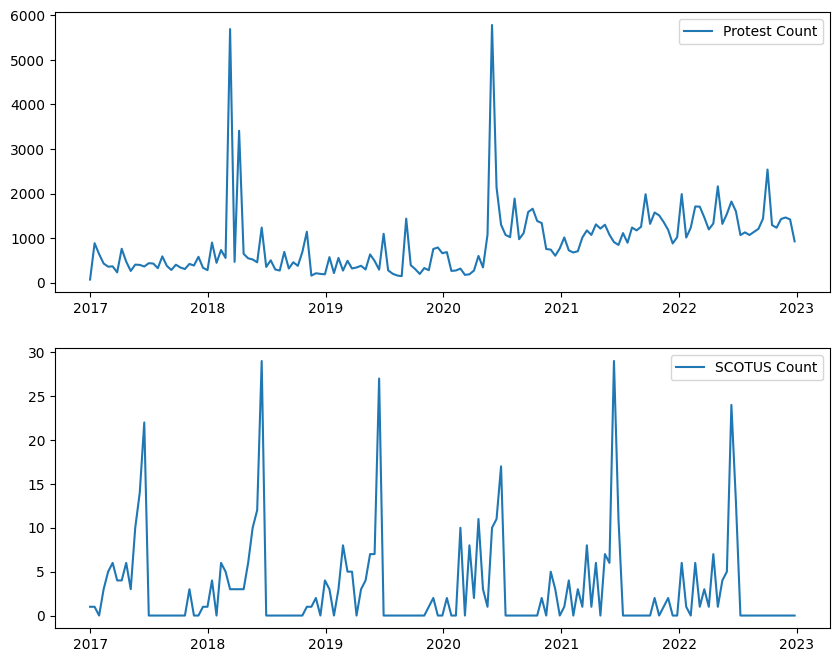

In [82]:
figure, axes = plt.subplots(2, 1, figsize=(10, 8))  # Creates a new figure with the specified size
axes[0].plot(df_dates['Date'], df_dates['protest_count'], label='Protest Count')
axes[0].legend()

axes[1].plot(df_dates['Date'], df_dates['scotus_count'], label='SCOTUS Count')
axes[1].legend()

plt.show()

In [83]:
df_dates.rename(columns={"Date": "ds", "protest_count": "y"}, inplace=True)
df_dates.head()

<ipython-input-83-18221547dfe0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dates.rename(columns={"Date": "ds", "protest_count": "y"}, inplace=True)


,ds,y,scotus_count
0,2017-01-01,70,1
1,2017-01-15,886,1
2,2017-01-29,641,0
3,2017-02-12,430,3
4,2017-02-26,359,5


In [84]:
model = Prophet(interval_width=0.95)
model.add_regressor('scotus_count', standardize=False)
model.fit(df_dates)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplk_f84a7/kzfjg6vi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplk_f84a7/xy0w_w37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20478', 'data', 'file=/tmp/tmplk_f84a7/kzfjg6vi.json', 'init=/tmp/tmplk_f84a7/xy0w_w37.json', 'output', 'file=/tmp/tmplk_f84a7/prophet_modeliq9tqw40/prophet_model-20250320161223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:12:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [85]:
model.params

OrderedDict([('lp__', array([[260.423]])),
             ('k', array([[0.188745]])),
             ('m', array([[0.0687885]])),
             ('delta',
              array([[ 1.71100e-09, -9.80985e-09, -6.01421e-09,  9.44813e-10,
                      -5.15038e-09, -1.38852e-09,  3.38318e-09,  4.07247e-09,
                       2.17684e-08,  4.45828e-08,  8.88828e-05,  1.18148e-03,
                       9.03105e-04,  6.54992e-06,  1.75203e-04,  6.74567e-04,
                       8.32253e-05,  7.45567e-09,  1.25157e-09,  3.44337e-09,
                       5.12872e-09, -4.36899e-09,  8.89924e-09,  8.75497e-10,
                      -6.17598e-09]])),
             ('sigma_obs', array([[0.114311]])),
             ('beta',
              array([[ 0.024842  , -0.0246092 , -0.0137777 , -0.0116642 ,  0.0246281 ,
                      -0.0116064 , -0.0259955 ,  0.00697583,  0.0167181 ,  0.0155359 ,
                       0.00227733, -0.00574446,  0.0153697 ,  0.01505   ,  0.0118731 ,
           

In [86]:
## Creating another df to remove the actual protest count and help us predict desired output.

df_dates_2 = df_dates_2[['Date', 'scotus_count']]
df_dates_2 = df_dates_2.rename(columns={'Date': 'ds'})
df_dates_2.reset_index(drop=True, inplace=True)

In [87]:
## Predicting the protest_count values here.

forecast_1 = model.predict(df_dates_2)
forecast_1 = forecast_1[['ds', 'yhat']]
forecast_1.head()

,ds,yhat
0,2023-01-08,1462.342274
1,2023-01-22,1451.533246
2,2023-02-05,1188.610985
3,2023-02-19,1273.855724
4,2023-03-05,1968.244660


In [88]:
## Dispalying a final df with the predicted values side by side with the actual
## protest count values, and scotus counts.

final_df = pd.concat([forecast_1, df_dates_2['scotus_count']], axis=1)
final_df.head()

,ds,yhat,scotus_count
0,2023-01-08,1462.342274,0
1,2023-01-22,1451.533246,2
2,2023-02-05,1188.610985,0
3,2023-02-19,1273.855724,6
4,2023-03-05,1968.244660,0


In [89]:
## Visualizing the results together to assess...

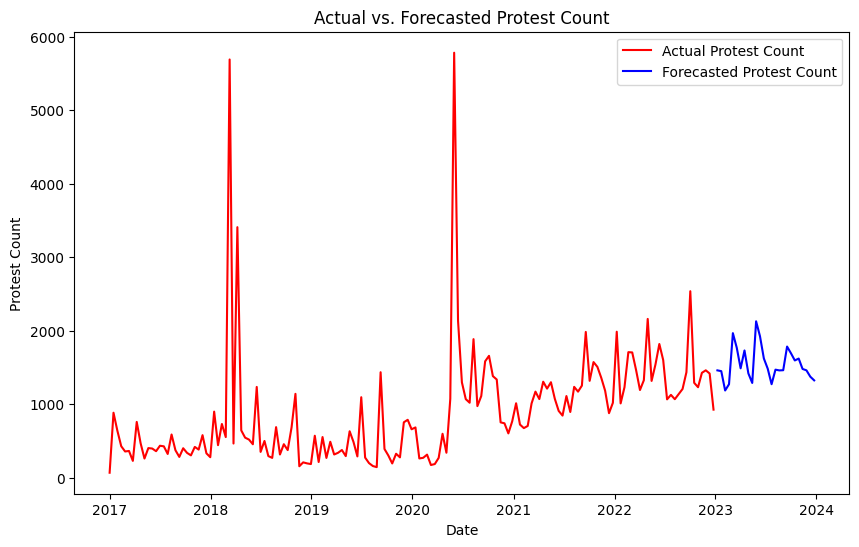

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(['ds'], df_dates['y'], color = 'red', label='Actual Protest Count')
plt.plot(final_df['ds'], final_df['yhat'], color = 'blue', label='Forecasted Protest Count')
plt.xlabel('Date')
plt.ylabel('Protest Count')
plt.title('Actual vs. Forecasted Protest Count')
plt.legend()
plt.show()